## Thử nghiệm với TF_IDF
- Notebook này sẽ dùng TF_IDF để convert văn bản thành vector và đưa vào các mô hình học máy cơ bản như Logistic Regression, SVM

In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import joblib

### Constants


In [11]:
RANDOM_STATE = 42
SPLIT_SIZE = 0.2

In [12]:
def predict_new_comment(pipeline, comment_list):
    """
    Dự đoán nhãn và xác suất cho một danh sách các comment.
    In ra kết quả cho comment đầu tiên trong danh sách.
    """
    if not isinstance(comment_list, list):
        comment_list = [comment_list]

    predicted = pipeline.predict(comment_list)
    prob = pipeline.predict_proba(comment_list)

    # Lấy kết quả cho comment đầu tiên (index 0)
    first_comment = comment_list[0]
    first_predicted = predicted[0]

    print(f"Comment: '{first_comment}'")
    print(f"Predicted labels (positive, negative): {first_predicted}")
    print("Probabilities:")

    label_names = ['positive', 'negative']
    for i, label in enumerate(label_names):
        probability_class1 = prob[i][0][1]
        print(f"  P({label}=1): {probability_class1:.4f}")

In [13]:
def draw_confusion_matrix(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    cm = multilabel_confusion_matrix(y_test, y_pred)
    
    # Tên nhãn cho các label
    label_names = ['Positive', 'Negative']
    
    # Vẽ confusion matrix
    fig, axes = plt.subplots(1, len(label_names), figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        # Vẽ confusion matrix cho từng nhãn
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[f'Not {label_names[i]}', label_names[i]])
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        ax.set_title(f'Confusion Matrix for {label_names[i]}')
    
    plt.tight_layout()
    plt.show()

### 1. Load data


In [14]:
train_df = pd.read_csv("../../data/training_data/train_data.csv")
generated_df = pd.read_csv("../../data/training_data/generated_data.csv")

In [15]:
train_df = pd.concat([train_df, generated_df], ignore_index=True)

In [16]:
train_df.groupby(['positive', 'negative']).size()

positive  negative
0         0            188
          1           1071
1         0           1017
          1             64
dtype: int64

In [17]:
train_df.shape

(2340, 7)

In [18]:
train_df.head()

,product_id,comment,comment_clean_stage1,comment_clean_stage2,rating,positive,negative
0,honor-x8b,"Đừng mua, ko có linh kiện.","đừng mua, không có linh kiện.",đừng mua không linh_kiện,1.0,0,1
1,honor-x8b,Mua online bên này báo ngoài ip ra thì hàng ko...,mua online bên này báo ngoài iphone ra thì hàn...,mua online bên báo iphone hàng không full box ...,2.0,0,1
2,honor-x8b,"Mạng yếu hay mất sóng, đổi máy khác được không","mạng yếu hay mất sóng, đổi máy khác được không?",mạng yếu hay mất sóng đổi máy khác được không,1.0,0,1
3,iphone-12,"Mua máy lướt được 2 hôm đã lỗi loa ngoài, lúc ...","mua máy lướt được hai hôm đã lỗi loa ngoài, lú...",mua máy lướt được hai hôm lỗi loa lúc bán nhân...,1.0,0,1
4,iphone-12,Mới mua mà dễ nóng quá. Khi sạc và nhất là bật...,mới mua mà dễ nóng quá. khi sạc và nhất là bật...,mới mua mà dễ nóng quá sạc nhất_là bật máy_ảnh...,2.0,0,1


In [19]:
# Xoá các hàng có comment_clean_stage2 là NaN
train_df = train_df.dropna(subset=['comment_clean_stage2'])

In [20]:
train_df.shape

(2339, 7)

In [21]:
X = train_df["comment_clean_stage2"]
y = train_df[["positive", "negative"]]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT_SIZE, random_state=RANDOM_STATE
)

In [23]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # xét cả unigram (từng từ đơn) và bigram (cặp từ liên tiếp)
    max_df=0.95,  # bỏ qua các từ xuất hiện trong >95% văn bản (thường là từ quá phổ biến)
    min_df=2,  # chỉ giữ các từ/cụm từ xuất hiện ở ít nhất 2 văn bản
)

In [24]:
# Logistic Regression với MultiOutputClassifier
logistic_classifier = MultiOutputClassifier(LogisticRegression(solver='liblinear', class_weight='balanced'))

In [25]:
pipeline_logistic = Pipeline([
    ('tfidf', tfidf),
    ('logistic_classifier', logistic_classifier)
])

In [26]:
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('logistic_classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    solver='liblinear')))])

In [27]:
y_pred = pipeline_logistic.predict(X_test)

In [28]:
# Đánh giá mô hình
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       208
           1       0.86      0.97      0.91       232

   micro avg       0.90      0.94      0.92       440
   macro avg       0.90      0.94      0.92       440
weighted avg       0.90      0.94      0.92       440
 samples avg       0.87      0.87      0.86       440



d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control thi

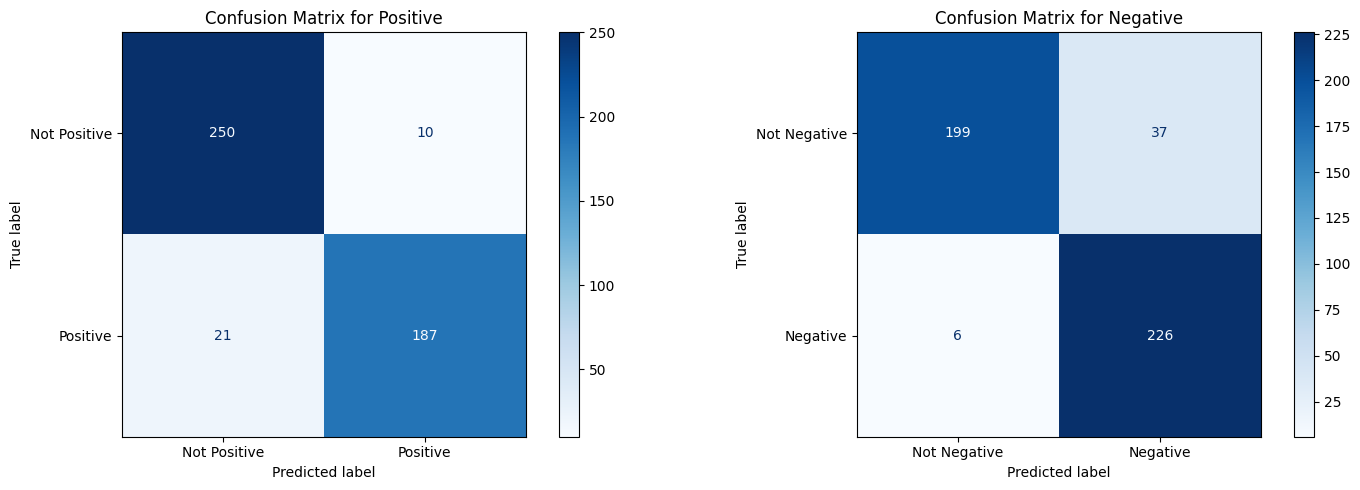

In [29]:
draw_confusion_matrix(pipeline_logistic, X_test, y_test)

In [30]:
predict_new_comment(pipeline_logistic, ["mua được tuần trả lại mất bao_nhiêu phần_trăm"])

Comment: 'mua được tuần trả lại mất bao_nhiêu phần_trăm'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.1208
  P(negative=1): 0.2800


In [31]:
predict_new_comment(pipeline_logistic, ["pin không dùng mà vẫn tụt"])

Comment: 'pin không dùng mà vẫn tụt'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.1713
  P(negative=1): 0.8093


In [32]:
predict_new_comment(pipeline_logistic, ["thế_giới di_động cường_lực honor tám không"])

Comment: 'thế_giới di_động cường_lực honor tám không'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.5241
  P(negative=1): 0.4851


In [33]:
joblib.dump(pipeline_logistic, './models/logistic.pkl')

['./models/logistic.pkl']

### Thử nghiệm với mô hình SVC

In [34]:
from sklearn.svm import SVC

In [35]:
svc_classifier = MultiOutputClassifier(SVC(kernel='linear', C=1, probability=True,))

In [36]:
pipeline_svc = Pipeline([
    ('tfidf', tfidf),
    ('svc_classifier', svc_classifier)
])

In [37]:
pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('svc_classifier',
                 MultiOutputClassifier(estimator=SVC(C=1, kernel='linear',
                                                     probability=True)))])

In [38]:
y_pred = pipeline_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       208
           1       0.89      0.94      0.91       232

   micro avg       0.92      0.93      0.92       440
   macro avg       0.92      0.93      0.92       440
weighted avg       0.92      0.93      0.92       440
 samples avg       0.86      0.86      0.86       440



d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control thi

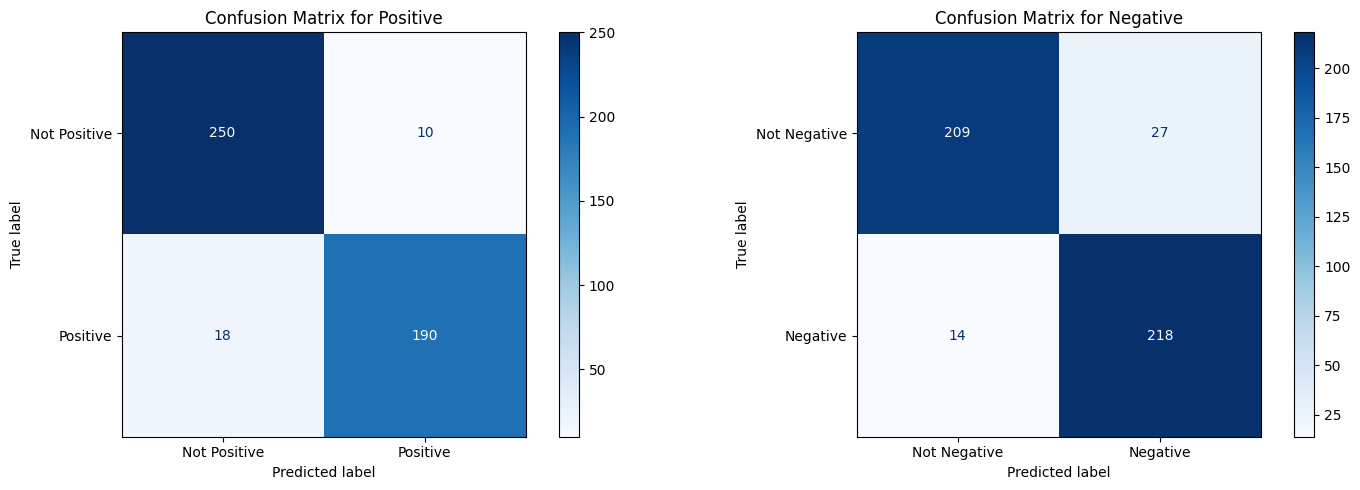

In [39]:
draw_confusion_matrix(pipeline_svc, X_test, y_test)

In [40]:
joblib.dump(pipeline_svc, './models/SVC.pkl')

['./models/SVC.pkl']

In [41]:
predict_new_comment(pipeline_svc, ["giá cao"])

Comment: 'giá cao'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0254
  P(negative=1): 0.9497


In [42]:
predict_new_comment(pipeline_svc, ["nhân viên khó chịu khi bán hàng"])

Comment: 'nhân viên khó chịu khi bán hàng'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.2185
  P(negative=1): 0.6073


In [43]:
predict_new_comment(pipeline_svc, ["đẹp lắm máy đẹp thank shop"])

Comment: 'đẹp lắm máy đẹp thank shop'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 1.0000
  P(negative=1): 0.0033


In [44]:
predict_new_comment(pipeline_svc, ["pin không dùng mà vẫn tụt"])

Comment: 'pin không dùng mà vẫn tụt'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0342
  P(negative=1): 0.9438


In [45]:
predict_new_comment(pipeline_svc, ["tại_sao iphone mới mua dùng lại bị nóng máy"])

Comment: 'tại_sao iphone mới mua dùng lại bị nóng máy'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0234
  P(negative=1): 0.9797


In [48]:
predict_new_comment(pipeline_svc, ["thế_giới di_động có dán cường_lực honor tám không"])

Comment: 'thế_giới di_động có dán cường_lực honor tám không'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.6262
  P(negative=1): 0.4471


In [38]:
predict_new_comment(pipeline_svc, ["mua được tuần trả lại mất bao_nhiêu phần_trăm"])

Comment: 'mua được tuần trả lại mất bao_nhiêu phần_trăm'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0081
  P(negative=1): 0.0185


In [39]:
predict_new_comment(pipeline_svc, ["tốt nhưng_mà đêm tuột"])

Comment: 'tốt nhưng_mà đêm tuột'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.9715
  P(negative=1): 0.5846


In [40]:
predict_new_comment(pipeline_svc, ["hỏi cài vấn_đề máy được không"])

Comment: 'hỏi cài vấn_đề máy được không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0351
  P(negative=1): 0.0529


In [41]:
predict_new_comment(pipeline_svc, ["điện_thoại xài siêu tốt"])

Comment: 'điện_thoại xài siêu tốt'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.9913
  P(negative=1): 0.0404


In [42]:
predict_new_comment(pipeline_svc, ["máy dùng rất ngon mượt rất đẹp không hài_lòng lắm nhân_viên bóc siu mà chưa đồng_ý cửa khách làm nghi_ngờ máy dùng máy thấy lớp bọc mới bóc không không nhận máy"])

Comment: 'máy dùng rất ngon mượt rất đẹp không hài_lòng lắm nhân_viên bóc siu mà chưa đồng_ý cửa khách làm nghi_ngờ máy dùng máy thấy lớp bọc mới bóc không không nhận máy'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.9873
  P(negative=1): 0.7410


In [43]:
predict_new_comment(pipeline_svc, ["tạm ổn nhưng pin hôm mua xài hai hôm tụt xuống lại tất_cả ổn"])

Comment: 'tạm ổn nhưng pin hôm mua xài hai hôm tụt xuống lại tất_cả ổn'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.9793
  P(negative=1): 0.8435


In [44]:
predict_new_comment(pipeline_svc, ["hỏi dán màn_hình chưa"])

Comment: 'hỏi dán màn_hình chưa'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.0075
  P(negative=1): 0.0344


In [45]:
predict_new_comment(pipeline_logistic, ["mới dùng tháng mong thế_giới di_động hướng_dẫn cách dùng hai sim iphone 12 dùng sim vật_lý muốn dùng thẻ sim tiện công_việc"])

Comment: 'mới dùng tháng mong thế_giới di_động hướng_dẫn cách dùng hai sim iphone 12 dùng sim vật_lý muốn dùng thẻ sim tiện công_việc'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.4027
  P(negative=1): 0.4517


In [46]:
predict_new_comment(pipeline_logistic, ["góp dòng hỏi thanh_toán khoản góp tháng bằng thẻ visa cửa_hàng được không"])

Comment: 'góp dòng hỏi thanh_toán khoản góp tháng bằng thẻ visa cửa_hàng được không'
Predicted labels (positive, negative): [0 0]
Probabilities:
  P(positive=1): 0.1696
  P(negative=1): 0.4509


In [47]:
predict_new_comment(pipeline_logistic, ["phát_hiện trong camera bụi được hỗ_trợ gì không"])

Comment: 'phát_hiện trong camera bụi được hỗ_trợ gì không'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.1633
  P(negative=1): 0.6121


In [48]:
predict_new_comment(pipeline_logistic, ["sao pin tối sáng bị tụt tầm"])

Comment: 'sao pin tối sáng bị tụt tầm'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.2406
  P(negative=1): 0.7980


In [49]:
predict_new_comment(pipeline_logistic, ["giao hàng đúng hạn đóng_gói cẩn_thận"])

Comment: 'giao hàng đúng hạn đóng_gói cẩn_thận'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.5592
  P(negative=1): 0.3572


In [50]:
predict_new_comment(pipeline_logistic, ["camera chụp hình đẹp"])

Comment: 'camera chụp hình đẹp'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.6967
  P(negative=1): 0.4110


### Demo

In [2]:
# Load best model
best_pipeline = joblib.load('./models/SVC.pkl')

In [3]:
import sys
sys.path.insert(0, "../../")

In [4]:
from src.shared.text_preprocessing import VietnamesePreprocessingWithoutSpellCheck

Current file path: D:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis
Thu mục gốc: D:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis
Using model path: D:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\attribute_extractor\vncorenlp


In [5]:
without_spellcheck_preprocessor = VietnamesePreprocessingWithoutSpellCheck()

In [8]:
# Nhập input liên tục từ người dùng cho đến khi người dùng nhập "exit"
while True:
    user_input = input("Nhập một comment hoặc 'exit' để thoát: ")
    
    if user_input.lower() == 'exit':
        print("Thoát chương trình.")
        break
    
    print("==================================")
    print("Comment gốc:", user_input)
    proceeded_input = without_spellcheck_preprocessor(user_input)
    predict_new_comment(best_pipeline, proceeded_input)

Comment gốc: pin tốt
Comment: 'pin tốt'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.9949
  P(negative=1): 0.0226
Comment gốc: giá hơi cao
Comment: 'giá hơi cao'
Predicted labels (positive, negative): [0 1]
Probabilities:
  P(positive=1): 0.0319
  P(negative=1): 0.9780
Comment gốc: giá hơi cao nhưng được cái là dùng siêu mượt
Comment: 'giá hơi cao nhưng được_cái_là dùng siêu mượt'
Predicted labels (positive, negative): [1 1]
Probabilities:
  P(positive=1): 0.6355
  P(negative=1): 0.8750
Comment gốc: pin tốt, màn hình đẹp
Comment: 'pin tốt màn_hình đẹp'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 1.0000
  P(negative=1): 0.0100
Comment gốc: pin tốt, màn hình đẹp nhưng hơi nóng máy
Comment: 'pin tốt màn_hình đẹp nhưng hơi nóng máy'
Predicted labels (positive, negative): [1 0]
Probabilities:
  P(positive=1): 0.9768
  P(negative=1): 0.2507
Comment gốc: pin tốt nhưng dùng nóng máy quá
Comment: 'pin tốt nhưng dùng nóng máy quá